# Import librairies

In [1]:
import os

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)

import sys
import random

sys.path.append("../utile")
sys.path.append("..")
from database import create_cnx, config_parse
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = "../data"
plt.rcParams["figure.figsize"] = (15, 15)
import base64

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Concatenate,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import Model, regularizers
from sklearn.cluster import KMeans
import keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import InputSpec

from model import Deep_Embedding_Model, DEC
from data import DataSet

from difflib import get_close_matches
import pickle
from pathlib import Path

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2022-03-07 14:27:09.744633: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices())

# print(K._get_available_gpus())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-07 14:27:10.953389: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-07 14:27:10.981173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 14:27:10.981219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 14:27:10.981262: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-07 14:27:10.987891: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 14:27:10.987954: I tensorflow/stream_exec

# Loading data and utile functions

## Loading data from database

In [3]:
# Select the data for a given season
season = "rabi"
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()
sql_request = (
    f"""SELECT DISTINCT * from data_SCOR WHERE Season = "{season}" ORDER BY RAND() """
)
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()

# Define custom class Dataset with the usefull features
df = pd.DataFrame(rows, columns=names)
numeric_features = [
    # "Area_Sown_Ha",
    # "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    # "Sum_Insured_Inr",
    # "Indemnity_Level",
]
textual_features = [
    "Crop",
    "State",
    # "Cluster",
]
df = df.drop_duplicates(ignore_index=True)
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=rows,
    columns=names,
)
# df = pd.DataFrame(rows, columns=names)
# Drop id column and columns that are completly empty
df.drop("id", inplace=True, axis=1)
df.dropna(axis=0, how="all", inplace=True)
# df.drop(axis=1,labels='index', inplace=True)
print(len(df))

/appli/notebooks/../utile/data.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.numeric_features = numeric_features
/appli/notebooks/../utile/data.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.textual_features = textual_features
/appli/notebooks/../utile/data.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.values_list_to_replace = values_list_to_replace


410997


# Preprocessing and encoding

## Pre-processing

In [4]:
# Keep only crop yields years with enough data
df.set_years_to_keep(drop=False)
# Subset dataframe to keep only numeric features, textual features, and crop yields years
df.subset_data()
# Preprocess numeric features
df.pre_process_numeric()
# Preprocess textual features
df.preprocess_textual()

{'2007_Yield': 3458.5794816695725, '2008_Yield': 3417.847702131436, '2009_Yield': 3884.7563655217823, '2010_Yield': 3835.3784565039587, '2011_Yield': 3885.5401339173136, '2012_Yield': 3912.15655156411, '2013_Yield': 3590.0603680096456, '2014_Yield': 3451.4673340809086}


/appli/notebooks/../utile/data.py:101: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.years_crop_yields = [f"{year}_Yield" for year in years_to_keep]


In [5]:
len(df)

410997

## Encoding

In [6]:
# Get embeddings dictionnary shape
df.set_dict_shape()
# Encode OHE feature
df.encode_ohe()
# Encode textual feature
df.encode_textual()
dict_shape = df.dict_shape

/appli/notebooks/../utile/data.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.dict_shape = dict_shape
/appli/notebooks/../utile/data.py:256: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.vocab = vocab


# Regression Model

In [7]:
# Define model
from model import Deep_Embedding_Model

Dense_embedding_model = Deep_Embedding_Model(
    dict_shape=dict_shape,
    textual_features=textual_features,
    numeric_features=numeric_features,
    outputs_shape=len(df.years_crop_yields),
).model()

2022-03-07 14:28:19.170209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 14:28:19.172093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 14:28:19.172131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 14:28:19.172517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/b

In [8]:
# If you want to display and save model architecture
# tf.keras.utils.plot_model(
#     Dense_embedding_model,
#     to_file="../material/images/Dense_embedding_model.png",
#     show_shapes=True,
#     show_layer_names=True,
# )

In [9]:
df.head()

,State,Crop,SI_Per_Ha_Inr_Ha,2007_Yield,2008_Yield,2009_Yield,2010_Yield,2011_Yield,2012_Yield,2013_Yield,2014_Yield
0,10,16,-0.221136,376.51001,300.399994,406.0,304.0,181.0,347.109985,434.920013,241.0
1,13,54,-0.066374,2728.00000,3047.000000,2984.0,2884.0,2854.0,3195.000000,2469.000000,2366.0
2,0,2,-0.045420,1747.00000,1461.000000,1403.0,1669.0,1581.0,1620.000000,1459.000000,1806.0
3,6,19,-0.528638,3458.57959,3417.847656,665.0,605.0,236.0,394.000000,673.000000,1175.0
4,13,2,-0.270424,3458.57959,1060.000000,899.0,957.0,1244.0,1148.000000,970.000000,388.0


## Model train and test

In [10]:
# Train/ test split input definition
inputs = df.df_train_test_split()
inputs_train = [
    inputs["textual"]["train"],
    inputs["numeric"]["train"],
    # input_ohe_dict_train,
]
inputs_test = [
    inputs["textual"]["test"],
    inputs["numeric"]["test"],
    # input_ohe_dict_train,
]

# Train model
epochs = 300
history = Dense_embedding_model.fit(
    inputs_train,  #
    inputs["label"]["train"],
    epochs=epochs,
    batch_size=1024,
    # validation_split = 0.3,
    validation_data=(inputs_test, inputs["label"]["test"]),
    verbose=1,
)

2022-03-07 14:28:20.385432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 14:28:20.386266: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


Epoch 1/300


2022-03-07 14:28:20.790872: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/281 [..............................] - ETA: 11:25 - loss: 45861640.0000 - mae: 3463.4548

2022-03-07 14:28:22.685295: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-07 14:28:22.685624: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


281/281 [==============================] - 5s 9ms/step - loss: 13686804.0000 - mae: 1525.7543 - val_loss: 4086103.2500 - val_mae: 878.8166
Epoch 2/300
281/281 [==============================] - 3s 10ms/step - loss: 4421664.0000 - mae: 933.4403 - val_loss: 3900205.5000 - val_mae: 860.9488
Epoch 3/300
281/281 [==============================] - 2s 9ms/step - loss: 4381902.5000 - mae: 927.6631 - val_loss: 3850517.2500 - val_mae: 854.1584
Epoch 4/300
281/281 [==============================] - 3s 9ms/step - loss: 4218918.5000 - mae: 914.2062 - val_loss: 3703795.7500 - val_mae: 842.4530
Epoch 5/300
281/281 [==============================] - 3s 9ms/step - loss: 4115827.7500 - mae: 892.2099 - val_loss: 3556097.2500 - val_mae: 818.9647
Epoch 6/300
281/281 [==============================] - 3s 9ms/step - loss: 4031959.7500 - mae: 874.0137 - val_loss: 3420403.2500 - val_mae: 755.8876
Epoch 7/300
281/281 [==============================] - 3s 9ms/step - loss: 3911633.0000 - mae: 836.2150 - val_loss:

In [11]:
# Test model
inputs_test = [
    inputs["textual"]["test"],
    inputs["numeric"]["test"],
    # input_ohe_dict_train,
]
Dense_embedding_model.evaluate(inputs_test, inputs["label"]["test"])
#

3854/3854 [==============================] - 17s 5ms/step - loss: 2763407.2500 - mae: 665.1551


[2763407.25, 665.1550903320312]

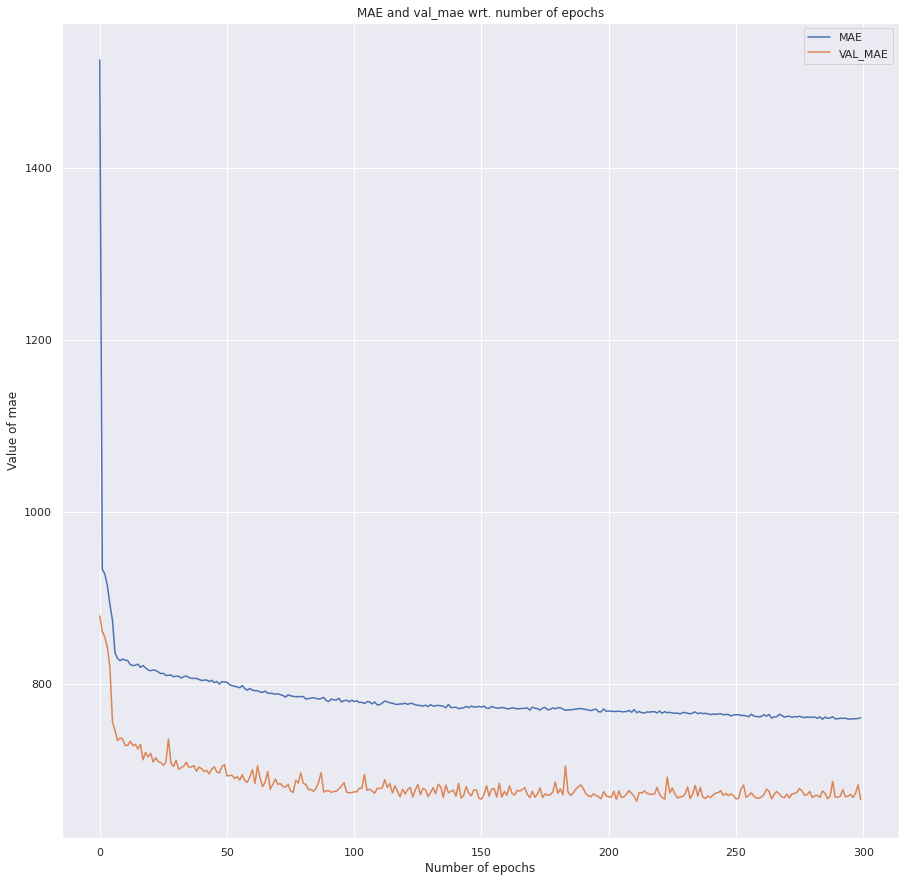

In [12]:
# Display training/ validation curves
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [13]:
# Display average and std of crop yields we want to predict
print(df[df.years_crop_yields].mean())
print()
print(df[df.years_crop_yields].std())

2007_Yield    3458.579590
2008_Yield    3417.846924
2009_Yield    3884.756348
2010_Yield    3835.378174
2011_Yield    3885.540527
2012_Yield    3912.156006
2013_Yield    3590.060547
2014_Yield    3451.467529
dtype: float32

2007_Yield    5793.324707
2008_Yield    5385.632324
2009_Yield    6772.699219
2010_Yield    6477.141602
2011_Yield    6301.543457
2012_Yield    6380.501953
2013_Yield    5858.584961
2014_Yield    6161.497070
dtype: float32


In [14]:
list_embedding_clustering = {}
# Textual feature we want to keep for the clustering space
textual_features_to_keep = ["State"]

for feature in textual_features_to_keep:
    # Get trained embedding layer and apply it to the input
    list_embedding_clustering[feature] = Flatten()(
        Dense_embedding_model.get_layer(f"Embedding_{feature}")(
            Dense_embedding_model.input[0][feature]
        )
    )
# If there are several features, concatenate all embeddings
concatted_clustering = Concatenate(name="concatted_clustering")(
    list(list_embedding_clustering.values())
)

# Define the model for the projection of data onto clustering space
model_feature_representation = Model(
    inputs=[
        {key: Dense_embedding_model.input[0][key] for key in textual_features_to_keep}
    ],
    outputs=concatted_clustering,
    name="model_feature_representation",
)

# CLustering model only with embedding of states 

The parts 5-6 are not needed to be run if you want to run cluster directly on the data for clustering, it is mostly to display results

In [23]:
# Apply embedding projection model to the input
X_train_embedded = model_feature_representation.predict(
    [inputs["textual"]["train"]["State"]]
)
inputs_total = {}
inputs_total["State"] = np.array(
    [*inputs["textual"]["train"]["State"], *inputs["textual"]["test"]["State"]]
)
X_train_embedded = model_feature_representation.predict([inputs_total])
# Take only unique values for the clustering (there are several times the same location in the dataset so we just keep one point for each location, i.e State for this notebook)
uniques = np.unique(X_train_embedded, axis=0)

In [25]:
# Get Davies Bouldin index for each number of cluster
davies_bouldin_scores = []
for k in range(2, 12):
    model_kmeans = KMeans(k).fit(uniques)
    davies_bouldin_scores.append(
        davies_bouldin_score(uniques, model_kmeans.predict(uniques))
    )

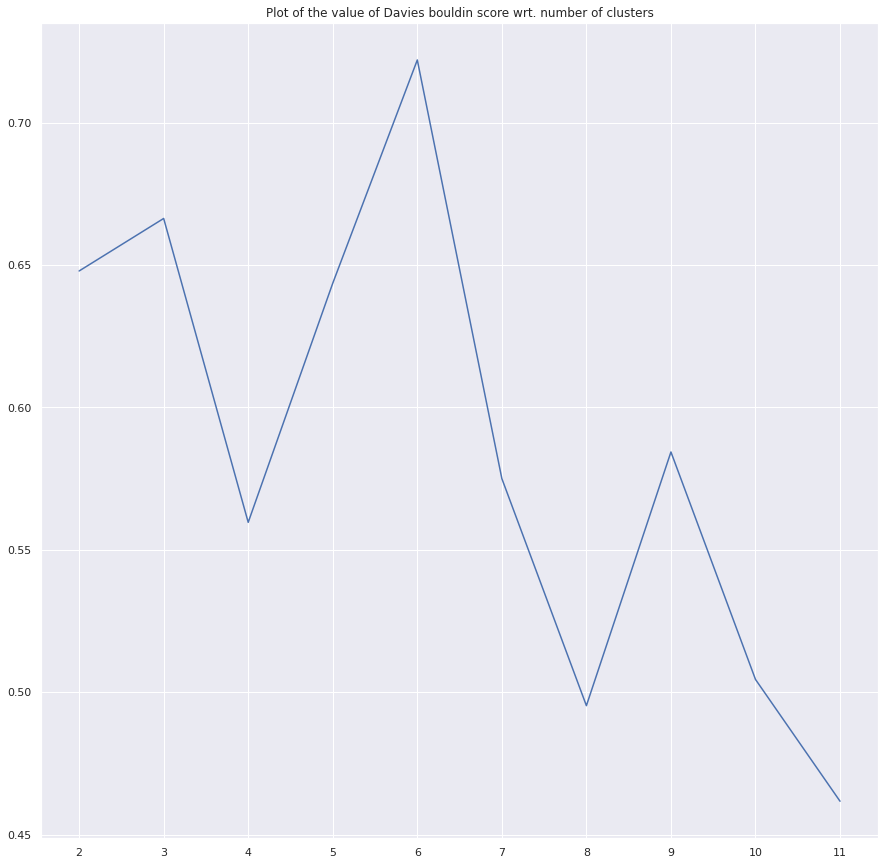

In [26]:
# Display the value of the index wrt. the number of clusters
sns.set_theme()
plt.plot(np.arange(2, 12), davies_bouldin_scores)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 12))

# Clusterize data of predict file

In [15]:
# Open the file we want to predict
path = os.path.join("..", "03_Prediction", f"States_Pred.csv")
df_to_predict = pd.read_csv(path)
df_to_predict_encode = df_to_predict.copy()

In [16]:
# Print there are some missing values (it is normal for Kharif and Rabi columns to be empty because we are going to make predictions for these columns
for column in df_to_predict.columns:
    print(
        f"The sparisity of the column {column} is {100*len(df_to_predict[df_to_predict[column].isna()])//len(df_to_predict)}%"
    )

The sparisity of the column State is 0%
The sparisity of the column Kharif is 100%
The sparisity of the column Rabi is 100%


In [18]:
# Match states between predictions file and the dataframe
def f(column, x):
    if x == "assam":
        return df.vocab[column]["bihar"]
    try:
        return df.vocab[column][x]
    except:
        # try:
        # Add fuzzy matching if the state is not directly recognized
        return df.vocab[column][get_close_matches(x, df.vocab[column])[0]]
        # except:
        #     # If there are no match even with fuzzy matching, return random value to run the model
        #     return df.vocab[column][random.choice(list(df.vocab[column].keys()))]


# Get encoding of states
df_to_predict_encode["State"] = df_to_predict_encode["State"].apply(
    lambda x: f("State", x)
)

In [54]:
# Apply embedding model on the dataset
# embeddings = model_feature_representation.predict([df_to_predict_encode])

embeddings = model_feature_representation.predict(
    [{"State": np.array(df_to_predict_encode["State"], dtype="int64")}]
)

embeddings /= np.linalg.norm(
    embeddings, axis=1, keepdims=True
)  # Run this cell if you want to normalize the embedding space to use cosine similarity rather than distance for the clustering

In [55]:
# Get Davies Bouldin index for each number of cluster
davies_bouldin_scores = []
for k in range(2, 12):
    model_kmeans = KMeans(k).fit(embeddings)
    davies_bouldin_scores.append(
        davies_bouldin_score(embeddings, model_kmeans.predict(embeddings))
    )

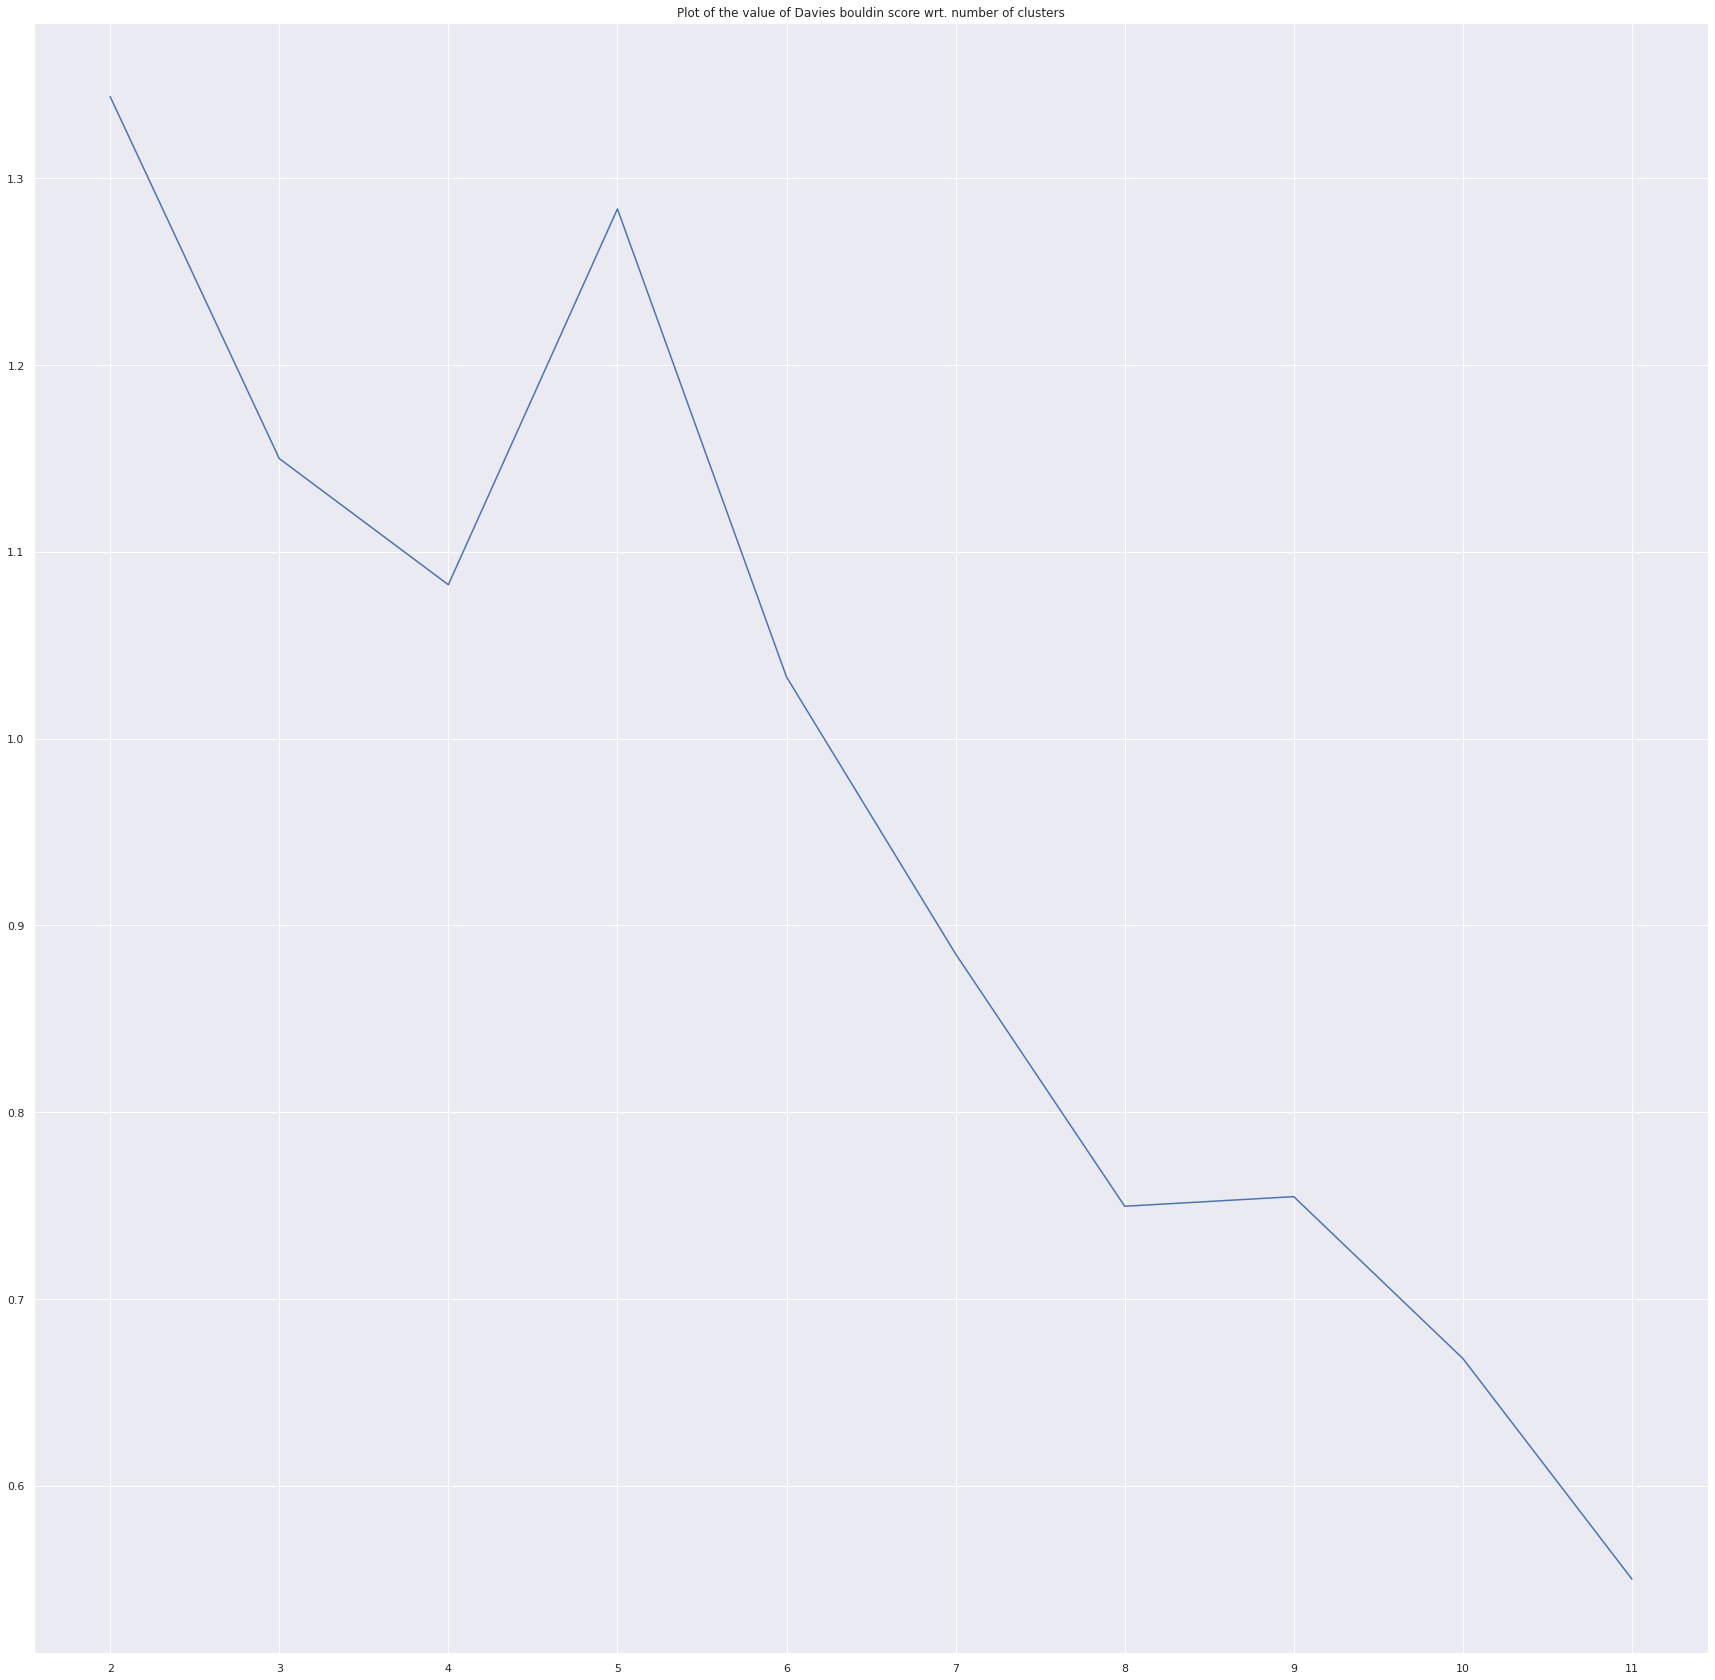

In [56]:
# Display the value of the index wrt. the number of clusters
sns.set_theme()
plt.plot(np.arange(2, 12), davies_bouldin_scores)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 12))

In [57]:
# Clusterize with KMeans
alpha = 0
n_clusters = 4
input_dim = 2
model_kmeans = KMeans(n_clusters).fit(embeddings)
centroids_init = model_kmeans.cluster_centers_

In [59]:
# Apply a PCA just to vizualise results
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

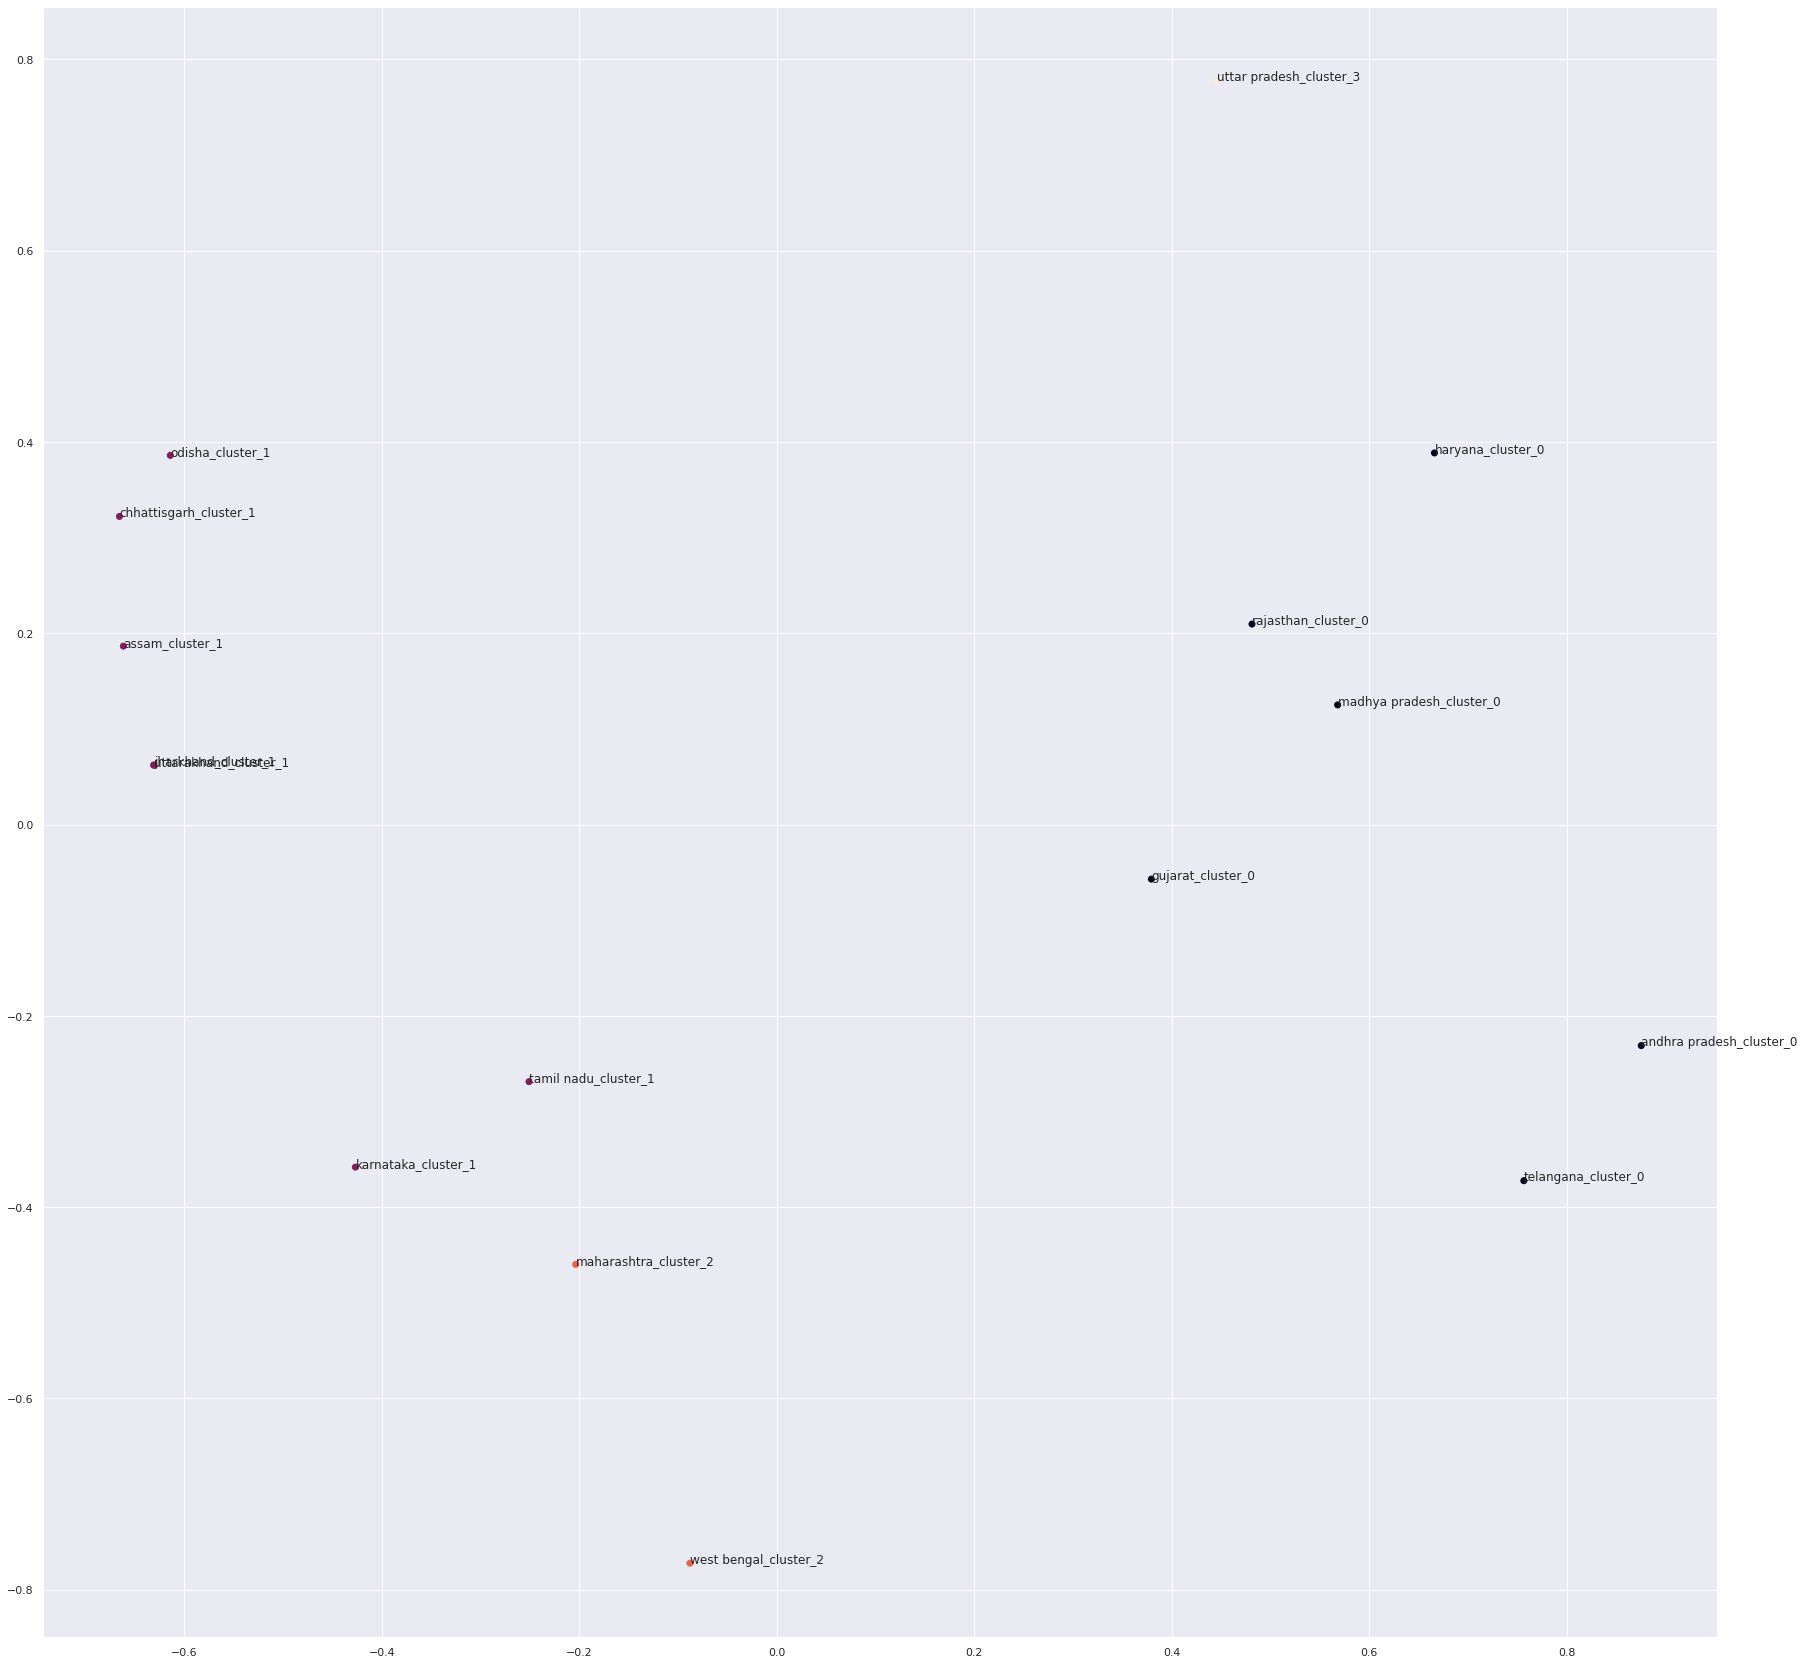

In [60]:
# Plot different States onto the space after PCA
plt.rcParams["figure.figsize"] = (30, 30)
fig, ax = plt.subplots()
ax.scatter(
    pca_embeddings[:, 0], pca_embeddings[:, 1], c=model_kmeans.labels_.astype(float)
)
for i, txt in enumerate(df_to_predict["State"].tolist()):
    ax.annotate(
        f"{txt}_cluster_{model_kmeans.labels_.astype(str)[i]}",
        (pca_embeddings[:, 0][i], pca_embeddings[:, 1][i]),
    )

In [63]:
pd.Series(model_kmeans.labels_).value_counts()

1    7
0    6
2    2
3    1
dtype: int64

In [64]:
# Print Davies Bouldin index
print(
    f"The value of Davie Bouldin index is {davies_bouldin_score(embeddings, model_kmeans.predict(embeddings))}"
)

The value of Davie Bouldin index is 0.9785310840644821


In [65]:
# Open the file in which to write predictions
try:
    df_to_write = pd.read_csv("../03_Prediction/predictions/state_wise.csv")
except:
    df_to_write = pd.read_csv(path)

In [66]:
# Set labels and write results down
df_to_write[season.title()] = model_kmeans.labels_
df_to_write.to_csv(f"../03_Prediction/predictions/state_wise.csv")

# Save model

In [55]:
# Get parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathdir = Path(
    os.path.join(
        parent_dir,
        f"pre_trained_models/state_wise/{season}/feature_encoding",
        "vocab.pkl",
    )
)
# Save embedding and regression models
with pathdir.open("wb") as f:
    pickle.dump(df.vocab, f)
model_feature_representation.save(
    f"../pre_trained_models/state_wise/{season}/feature_representation"
)
# DEC_model.model.save(f"../pre_trained_models/state_wise/{season}/DEC")
# DEC_model.model_AE.save(f"../pre_trained_models/{season}/AE")
Dense_embedding_model.save(f"../pre_trained_models/state_wise/{season}/dense_embedding")

/appli
/appli/pre_trained_models/state_wise/rabi/feature_encoding/vocab.pkl


2022-02-02 13:37:27.470546: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../pre_trained_models/state_wise/rabi/feature_representation/assets


INFO:tensorflow:Assets written to: ../pre_trained_models/state_wise/rabi/feature_representation/assets


INFO:tensorflow:Assets written to: ../pre_trained_models/state_wise/rabi/dense_embedding/assets


INFO:tensorflow:Assets written to: ../pre_trained_models/state_wise/rabi/dense_embedding/assets
